In [1]:
from fastai.vision.all import *
from moving_mnist.models.seq2seq import *
from moving_mnist.models.conv_rnn import StackUnstack, StackLoss, MultiImageDice
from moving_mnist.data import *

In [2]:
if torch.cuda.is_available():
    torch.cuda.set_device(0)
    print(torch.cuda.get_device_name())

Quadro RTX 8000


# Train Example:

We wil predict:
- `n_in`: 5 images
- `n_out`: 5 images  
- `n_obj`: up to 3 objects

In [3]:
Path.cwd()

Path('/home/tcapelle/SteadySun/moving_mnist')

In [4]:
DATA_PATH = Path.cwd()/'data'

In [5]:
ds = MovingMNIST(DATA_PATH, n_in=5, n_out=5, n_obj=[1,2], th=None)

In [6]:
train_tl = TfmdLists(range(7500), ImageTupleTransform(ds))
valid_tl = TfmdLists(range(100), ImageTupleTransform(ds))

In [7]:
dls = DataLoaders.from_dsets(train_tl, valid_tl, bs=64,
                             after_batch=[Normalize.from_stats(*mnist_stats)]).cuda()

In [8]:
mse_loss = StackLoss(MSELossFlat(axis=1))
metrics = []

Left: Input, Right: Target

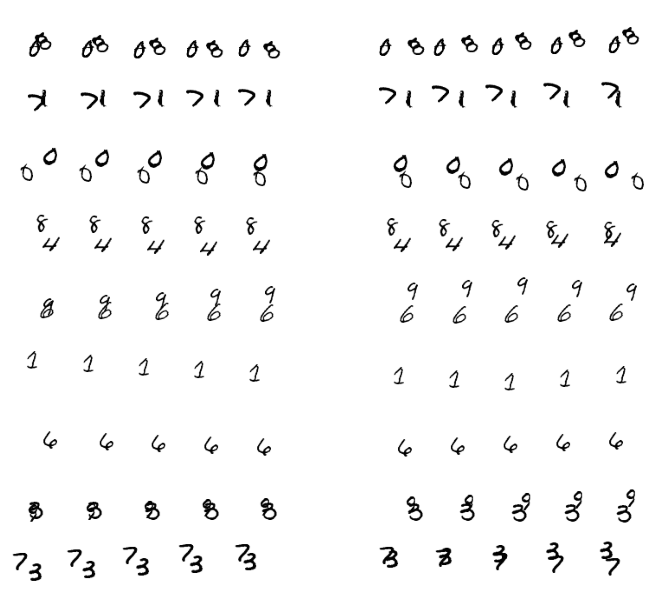

In [9]:
dls.show_batch()

## Baseline

`StackUnstack` takes cares of stacking the list of images into a fat tensor, and unstacking them at the end, we will need to modify our loss function to take a list of tensors as input and target.

In [10]:
model = StackUnstack(Seq2Seq(5, ch_out=1), dim=1).cuda()

As the `ImageSeq` is a `tuple` of images, we will need to stack them to compute loss.

In [11]:
learn = Learner(dls, model, loss_func=mse_loss, metrics=metrics, cbs=[Encoderloss(mse_loss)])

I have a weird bug that if I use `nn.LeakyReLU` after doing `learn.lr_find()` the model does not train (the loss get stucked).

In [12]:
learn.lr_find()

KeyboardInterrupt: 

In [84]:
learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,time
0,0.396913,0.346504,00:33
1,0.321300,0.322176,00:33
2,0.293490,0.271025,00:34
3,0.274885,0.261040,00:34
4,0.258336,0.243364,00:34
5,0.245453,0.238147,00:34
6,0.235843,0.230981,00:34
7,0.228605,0.231410,00:34
8,0.224969,0.222423,00:34
9,0.223850,0.216631,00:34


In [85]:
p,t = learn.get_preds()

As you can see, the results is a list of 5 tensors with 100 samples each.

In [86]:
len(p), p[0].shape

(5, torch.Size([100, 1, 64, 64]))

In [87]:
def show_res(t, idx, argmax=False):
    if argmax:
        im_seq = ImageSeq.create([t[i][idx].argmax(0).unsqueeze(0) for i in range(5)], TensorMask)
    else:
        im_seq = ImageSeq.create([t[i][idx] for i in range(5)])
    im_seq.show(figsize=(8,4));

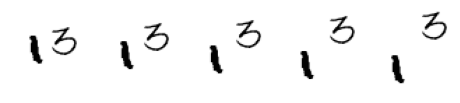

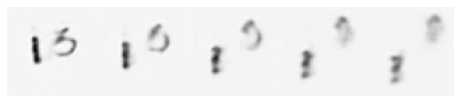

In [88]:
k = random.randint(0,99)
show_res(t,k)
show_res(p,k, False)

## Teacher Forcing

In [13]:
model = StackUnstack(Seq2Seq(5, ch_out=1, ks=3, n_layers=3, debug=False), dim=1).cuda()

In [14]:
learn = Learner(dls, model, loss_func=mse_loss, metrics=metrics, cbs=[TeacherForcing(6), Encoderloss(mse_loss, alpha=1)])

In [15]:
learn.lr_find()

KeyboardInterrupt: 

In [92]:
learn.fit_one_cycle(20, 1e-3)

epoch,train_loss,valid_loss,time
0,0.594216,0.586115,00:49
1,0.367286,0.409736,00:49
2,0.331258,0.353343,00:49
3,0.306421,0.313459,00:49
4,0.289310,0.269096,00:48
5,0.268390,0.251388,00:48
6,0.263391,0.248886,00:48
7,0.245598,0.231160,00:49
8,0.236413,0.220519,00:48
9,0.228097,0.226145,00:48


In [93]:
p,t = learn.get_preds()

As you can see, the results is a list of 5 tensors with 100 samples each.

In [94]:
len(p), p[0].shape

(5, torch.Size([100, 1, 64, 64]))

In [95]:
def show_res(t, idx, argmax=False):
    if argmax:
        im_seq = ImageSeq.create([t[i][idx].argmax(0).unsqueeze(0) for i in range(5)], TensorMask)
    else:
        im_seq = ImageSeq.create([t[i][idx] for i in range(5)])
    im_seq.show(figsize=(8,4));

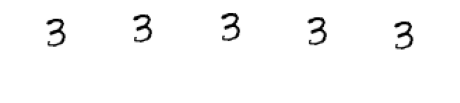

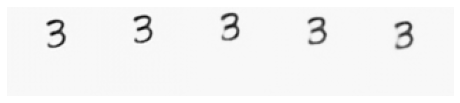

In [52]:
k = random.randint(0,99)
show_res(t,k)
show_res(p,k, False)

## PhyCell

In [10]:
model = StackUnstack(Seq2Seq(5, ch_out=1, ks=3, n_layers=3, use_phy=True, debug=False), dim=1).cuda()

In [11]:
learn = Learner(dls, model, loss_func=mse_loss, metrics=metrics, cbs=[TeacherForcing(6), Encoderloss(mse_loss, alpha=1)])

SuggestedLRs(lr_min=0.025118863582611083, lr_steep=0.00019054606673307717)

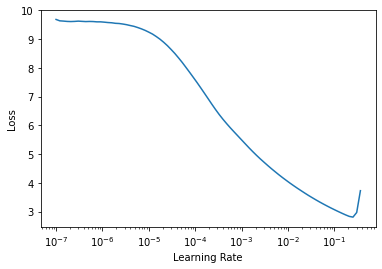

In [12]:
learn.lr_find()

In [13]:
learn.fit_one_cycle(12, 1e-3)

epoch,train_loss,valid_loss,time
0,0.836790,0.524623,00:32
1,0.481536,0.446799,00:33
2,0.389618,0.367498,00:33
3,0.356378,0.334580,00:33
4,0.344300,0.335997,00:33
5,0.331020,0.299111,00:32
6,0.326916,0.341641,00:32
7,0.311258,0.308030,00:32
8,0.304423,0.289734,00:32
9,0.294880,0.278185,00:33


In [14]:
p,t = learn.get_preds()

As you can see, the results is a list of 5 tensors with 100 samples each.

In [15]:
len(p), p[0].shape

(5, torch.Size([100, 1, 64, 64]))

In [16]:
def show_res(t, idx, argmax=False):
    if argmax:
        im_seq = ImageSeq.create([t[i][idx].argmax(0).unsqueeze(0) for i in range(5)], TensorMask)
    else:
        im_seq = ImageSeq.create([t[i][idx] for i in range(5)])
    im_seq.show(figsize=(8,4));

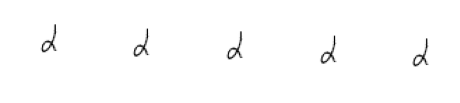

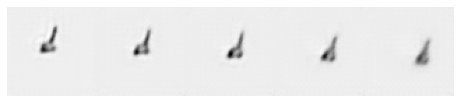

In [17]:
k = random.randint(0,99)
show_res(t,k)
show_res(p,k, False)